In [ ]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import geopandas as gpd
import pyogrio
import xarray as xr
import glob
import os

In [38]:
import py7zr

### Import shared files

In [36]:
#Flowlines (by COMID)
nhd_dir = r'../DATA/NHDPlusPN/NHDPlus17/NHDSnapshot/'
dbfhydro = glob.glob(nhd_dir + '*/*.dbf') 
flowlines_all = gpd.read_file(dbfhydro[0])
flowlines_all.set_index('COMID', inplace = True)
flowlines_all.head()

/opt/miniconda3/envs/temp-data-env/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,WBAREACOMI,FTYPE,FCODE,SHAPE_LENG,ENABLED,GNIS_NBR,geometry
COMID,,,,,,,,,,,,,,
9301535,1999-10-08,Medium,None,None,0.999,09040002011583,Uninitialized,0,StreamRiver,46006,0.011661,True,0,"LINESTRING Z (-114.05855 48.99999 0, -114.0583..."
22968128,2001-03-02,Medium,None,None,0.134,10030104009812,Uninitialized,0,StreamRiver,46003,0.001671,True,0,"LINESTRING Z (-113.00089 47.46274 0, -113.0020..."
22968138,2001-03-02,Medium,None,None,0.217,10030104009813,Uninitialized,0,StreamRiver,46003,0.002145,True,0,"LINESTRING Z (-113.0013 47.45837 0, -113.00137..."
23135995,2001-02-07,Medium,None,None,0.916,16010102003533,Uninitialized,0,StreamRiver,46003,0.010671,True,0,"LINESTRING Z (-111.06214 42.50841 0, -111.0619..."
23135997,2001-02-07,Medium,None,None,1.865,16010102003534,Uninitialized,0,StreamRiver,46003,0.019193,True,0,"LINESTRING Z (-111.04516 42.51372 0, -111.0447..."


In [37]:
# Spatial metrics (time invariant)
spatial_data_all = pd.read_csv('../DATA/Stream_Temp/spatial_data.csv')
spatial_data_fill = spatial_data_all.fillna(-9999)
spatial_data_fill.head()

,COMID,cov.length_km,cov.stream_order,cov.path_length,cov.tot.da.sqkm,cov.elev_max_smo,cov.elev_min_smo,cov.slope,cov.sinuosity,cov.lat_v,...,cov.pct_urb_all_ws,cov.canopy_rca,cov.canopy_line,cov.area_sqkm,cov.canopy_ws,cov.dam_name,cov.proportion_dam_influenced,cov.distance_below_dam,cov.dam_hgt_m,cov.dam_main_use
0,9301535,0.999,-9999.0,-9999.000,-9999.0000,-9999.0,-9999.0,-9999.000000,1.47,-9999.000000,...,-9999.000000,-9999.0,-9999.0,-9999.0000,-9999.000000,-9999,-9999.000000,-9999.000,-9999.0,-9999
1,22226592,0.733,-9999.0,-9999.000,-9999.0000,-9999.0,-9999.0,-9999.000000,1.13,-9999.000000,...,-9999.000000,-9999.0,-9999.0,-9999.0000,-9999.000000,-9999,-9999.000000,-9999.000,-9999.0,-9999
2,22226600,6.117,-9999.0,-9999.000,-9999.0000,-9999.0,-9999.0,-9999.000000,1.62,-9999.000000,...,-9999.000000,-9999.0,-9999.0,-9999.0000,-9999.000000,-9999,-9999.000000,-9999.000,-9999.0,-9999
3,22877591,0.247,6.0,1290.195,28030.5369,56102.0,55932.0,0.006883,1.00,48.558399,...,0.946698,89.0,90.0,1.9161,88.592748,Libby,0.831332,71.294,129.0,Hydroelectricity
4,22877593,0.055,3.0,1290.442,58.4136,56129.0,56102.0,0.004909,1.00,48.556999,...,0.000000,90.0,90.0,0.4284,90.227047,-9999,-9999.000000,-9999.000,-9999.0,-9999


In [9]:
#spatial_data_fill["geometry"] = spatial_data_fill.COMID.map(flowlines_all.geometry)
#spatial_data_fill.set_index('COMID', inplace=True)

In [18]:
covariate_metadata = pd.read_csv('../DATA/Stream_Temp/covariate_metadata.csv', nrows = 80)
covariate_metadata

,COVARIATE,UNITS,SYMBOL,DESCRIPTION,DATA SOURCE (Retrospective),DATA SOURCE (GCM Scenarios)
0,COMID,unitless,NaN,unique identifier for matching to stream reach...,NHDv2 attributes; McKay et al. (2012),NaN
1,cov.antec_air_temp,C,Tl,Antecedent air temperature (summarized by the ...,Calculated; Siegel et al. (2023),Calculated as in Siegel et al. (2023)
2,cov.air_temp_mean_ws,C,Tws,mean daily air temperature in upstream watershed,PRISM; Di Luzio et al. (2008),RMJOC(2018); IPCC (2014); USCRT
3,cov.SWE_ws,mm,Sws,Mean daily snowpack snow-water equivalent (SWE...,National Snow and Ice Data Center; Broxton et ...,RMJOC(2018) intermediate modeling product
4,cov.daylength_hours,h,DL,daylength,DayMet; https://daymet.ornl.gov/,DayMet; https://daymet.ornl.gov/
...,...,...,...,...,...,...
75,cov.sinuosity,unitless,not used,sinuosity (curviness) of reach,StreamCat; Hill et al. (2016),NaN
76,cov.stream_order,unitless,not used,Strahler stream order,NHDv2 attributes; McKay et al. (2012),NaN
77,cov.tot.da.sqkm,km^2,not used,total drainage area to reach,NHDv2 attributes; McKay et al. (2012),NaN
78,cov.wt_dep_cat,cm,not used,mean seasonal water table depth of soils in ca...,StreamCat; Hill et al. (2016),NaN


In [19]:
gcm_metadata = pd.read_csv('../DATA/Stream_Temp/gcm_metadata.csv', nrows = 10)
gcm_metadata

,Global Climate Model short name,GCM long name,Country,Agency,Coupled Model Intercomparison Project version,Emissions scenario,Downscaling method,Hydrology model,Network routing
0,CanESM2,Canadian Earth System Model version 2,Canada,Canadian Centre for Climate Modeling and Analysis,5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
1,CCSM4,Community Climate System Model version 4,USA,"National Center of Atmospheric Research, USA",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
2,CNRM-CM5,National Center for Meteorological Research Mo...,France,"National Centre of Meteorological Research, Fr...",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
3,CSIRO-Mk3-6-0,Commonwealth Scientific and Industrial Researc...,Australia,Commonwealth Scientific and Industrial Researc...,5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
4,GDFL-ESM2M,Global Fluid Dynamics Lab's Earth Systems Mode...,USA,"NOAA Geophysical Fluid Dynamics Laboratory, USA",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
5,HadGEM-CC365,"Hadley Centre Global Environmental Model, Clim...",UK,"Met Office Hadley Center, UK",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
6,HadGEM2-ES,"Hadley Centre Global Environmental Model, Eart...",UK,"Met Office Hadley Center, UK",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
7,inmcm4,"Institute of Numerical Mathematics, Coupled Mo...",Russia,"Institute of Numerical Mathematics, Russia",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
8,IPSL-CM5A-MR,Institut Pierre Simon Laplace Climate Model,France,"Institut Pierre Simon Laplace, France",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
9,MIROC5,Model for Interdisciplinary Research on Climat...,Japan,Atmosphere and Ocean Research Institute (The U...,5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)


In [20]:
gcms = list(gcm_metadata.iloc[:, 0].values)
gcms

['CanESM2',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'GDFL-ESM2M',
 'HadGEM-CC365',
 'HadGEM2-ES',
 'inmcm4',
 'IPSL-CM5A-MR',
 'MIROC5']

In [21]:
shortname_dict = {i+1:gcms[i] for i in list(range(10))}
shortname_dict

{1: 'CanESM2',
 2: 'CCSM4',
 3: 'CNRM-CM5',
 4: 'CSIRO-Mk3-6-0',
 5: 'GDFL-ESM2M',
 6: 'HadGEM-CC365',
 7: 'HadGEM2-ES',
 8: 'inmcm4',
 9: 'IPSL-CM5A-MR',
 10: 'MIROC5'}

In [ ]:
# the following use ~ mm/21/yy dates for cutting (i.e. spring starts on March 21) - per Aimee

def assign_season(doy):
    """Assigns a season based on the day of year (doy)."""
    if 1 <= doy <= 79:
        return "winter"
    elif 80 <= doy <= 171:
        return "spring"
    elif 172 <= doy <= 263:
        return "summer"
    elif 264 <= doy <= 356:
        return "fall"
    else:
        return "winter"

In [33]:
temp_dir = '/Volumes/Elements/URycki/temp_data/'

In [ ]:
periods = {'2020s': list(range(2020, 2030)), 
           '1990s': list(range(1990, 2000)), 
           '2050s': list(range(2050, 2060)), 
           '2080s': list(range(2080, 2090))}

In [202]:
temp_dir_gcms = os.path.join(temp_dir, 'preds_GCM/')
temp_files_gcms = glob.glob(temp_dir_gcms + '*.nc')
print(len(temp_files_gcms))
temp_files_gcms.sort()

1316


In [222]:
for i in range(130, len(temp_files_gcms)):
    cur_file = temp_files_gcms[i]
    cur_huc = int(cur_file.split('/')[-1][:-3])

    preds = xr.open_dataset(cur_file, decode_times=True)
    predsdf = preds.to_dataframe(dim_order = ['COMID', 'GCM', 'date'])
    preds_flat = predsdf.reset_index()

    if predsdf.shape[0] > 0:
        cur_huc_anoms = []
        cur_comids = list(preds_flat.COMID.unique())
        for j in cur_comids:
            cur_preds = preds_flat[preds_flat.COMID == j]
            cur_ens_med = cur_preds.groupby('date').median().drop('GCM', axis =1)
            cur_ens_med['doy'] = cur_ens_med.index.dayofyear
            cur_ens_med['season'] = cur_ens_med['doy'].apply(assign_season)
    
            cur_anomolies = {}
            for dec in list(periods.keys()):
                if dec == '2020s': cur_anomolies[dec] = cur_ens_med[cur_ens_med.index.year.isin(periods[dec])].groupby('season').median()['prd.stream_temp']
                else: cur_anomolies[dec] = cur_ens_med[cur_ens_med.index.year.isin(periods[dec])].groupby('season').median()['prd.stream_temp'].subtract(cur_anomolies['2020s'])
    
            cur_seas_anomolies = pd.DataFrame(cur_anomolies)
            cur_huc_anoms.append(cur_seas_anomolies)
        
        huc_anoms = pd.concat(cur_huc_anoms, keys = cur_comids)
        huc_anoms.to_csv(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.csv'))
        with py7zr.SevenZipFile(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.7z'), 'w') as archive:
            archive.write(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.csv'))
        os.remove(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.csv')) 

OSError: [Errno -101] NetCDF: HDF error: '/Volumes/Elements/URycki/temp_data/preds_GCM/1702000720.nc'

In [223]:
i

222

In [225]:
k = 2

In [226]:
cur_file_ck = temp_files_gcms[k]
cur_file_ck

'/Volumes/Elements/URycki/temp_data/preds_GCM/1701010109.nc'

In [227]:
preds_ck = xr.open_dataset(cur_file_ck, decode_times=True)
predsdf_ck = preds_ck.to_dataframe(dim_order = ['COMID', 'GCM', 'date'])
preds_flat_ck = predsdf_ck.reset_index()

In [228]:
preds_flat_ck

,COMID,GCM,date,prd.stream_temp
0,22878617,1,1950-01-01,NaN
1,22878617,1,1950-01-02,NaN
2,22878617,1,1950-01-03,0.000000
3,22878617,1,1950-01-04,0.076190
4,22878617,1,1950-01-05,0.000000
...,...,...,...,...
4382955,22882373,10,2099-12-27,3.492679
4382956,22882373,10,2099-12-28,3.853480
4382957,22882373,10,2099-12-29,3.273735
4382958,22882373,10,2099-12-30,5.010366


In [230]:
cur_com = preds_flat_ck.COMID.unique()[-1]

In [231]:
cur_com

np.int32(22882373)

In [235]:
cur_preds_ck = preds_flat_ck[preds_flat_ck.COMID == cur_com]

In [236]:
cur_preds_ck

,COMID,GCM,date,prd.stream_temp
3835090,22882373,1,1950-01-01,NaN
3835091,22882373,1,1950-01-02,NaN
3835092,22882373,1,1950-01-03,NaN
3835093,22882373,1,1950-01-04,NaN
3835094,22882373,1,1950-01-05,NaN
...,...,...,...,...
4382955,22882373,10,2099-12-27,3.492679
4382956,22882373,10,2099-12-28,3.853480
4382957,22882373,10,2099-12-29,3.273735
4382958,22882373,10,2099-12-30,5.010366


In [245]:
cur_preds_ck[cur_preds_ck.date == '12/31/2099']

,COMID,GCM,date,prd.stream_temp
3889876,22882373,1,2099-12-31,1.660377
3944663,22882373,2,2099-12-31,2.548640
3999450,22882373,3,2099-12-31,1.288398
4054237,22882373,4,2099-12-31,3.819269
4109024,22882373,5,2099-12-31,1.723519
4163811,22882373,6,2099-12-31,5.566496
4218598,22882373,7,2099-12-31,4.049389
4273385,22882373,8,2099-12-31,2.672233
4328172,22882373,9,2099-12-31,NaN
4382959,22882373,10,2099-12-31,4.310524


In [247]:
np.nanmedian(cur_preds_ck[cur_preds_ck.date == '12/31/2099']['prd.stream_temp'])

np.float64(2.67223326861739)

In [237]:
cur_ens_med_ck = cur_preds_ck.groupby('date').median().drop('GCM', axis =1)
cur_ens_med_ck

,COMID,prd.stream_temp
date,,
1950-01-01,22882373.0,NaN
1950-01-02,22882373.0,NaN
1950-01-03,22882373.0,0.109532
1950-01-04,22882373.0,0.132757
1950-01-05,22882373.0,0.223510
...,...,...
2099-12-27,22882373.0,2.490783
2099-12-28,22882373.0,2.087694
2099-12-29,22882373.0,2.058112


In [250]:
cur_preds_ck.groupby('date').median().drop('GCM', axis =1)

,COMID,prd.stream_temp
date,,
1950-01-01,22882373.0,NaN
1950-01-02,22882373.0,NaN
1950-01-03,22882373.0,0.109532
1950-01-04,22882373.0,0.132757
1950-01-05,22882373.0,0.223510
...,...,...
2099-12-27,22882373.0,2.490783
2099-12-28,22882373.0,2.087694
2099-12-29,22882373.0,2.058112


In [239]:
cur_ens_med_ck['doy'] = cur_ens_med_ck.index.dayofyear
cur_ens_med_ck['season'] = cur_ens_med_ck['doy'].apply(assign_season)
cur_ens_med_ck

,COMID,prd.stream_temp,doy,season
date,,,,
1950-01-01,22882373.0,NaN,1,winter
1950-01-02,22882373.0,NaN,2,winter
1950-01-03,22882373.0,0.109532,3,winter
1950-01-04,22882373.0,0.132757,4,winter
1950-01-05,22882373.0,0.223510,5,winter
...,...,...,...,...
2099-12-27,22882373.0,2.490783,361,winter
2099-12-28,22882373.0,2.087694,362,winter
2099-12-29,22882373.0,2.058112,363,winter


In [251]:
periods

{'2020s': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029],
 '1990s': [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999],
 '2050s': [2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059],
 '2080s': [2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089]}

In [276]:
vals = cur_ens_med_ck[(cur_ens_med_ck.index.year.isin(periods['2020s'])) & (cur_ens_med_ck.season == 'winter')]['prd.stream_temp'].values

In [277]:
np.nanmedian(vals)

np.float64(1.32164705893292)

In [278]:
np.median(vals)

np.float64(1.32164705893292)

In [280]:
cur = cur_ens_med_ck[cur_ens_med_ck.index.year.isin(periods['2020s'])].groupby('season').median()['prd.stream_temp']
cur

season
fall       3.363799
spring     7.035941
summer    13.860170
winter     1.321647
Name: prd.stream_temp, dtype: float64

In [283]:
fifties = cur_ens_med_ck[cur_ens_med_ck.index.year.isin(periods['2050s'])].groupby('season').median()['prd.stream_temp']
fifties

season
fall       4.102839
spring     8.075323
summer    14.787528
winter     1.470753
Name: prd.stream_temp, dtype: float64

In [295]:
nineties = cur_ens_med_ck[cur_ens_med_ck.index.year.isin(periods['1990s'])].groupby('season').median()['prd.stream_temp']
nineties

season
fall       3.158271
spring     6.414733
summer    12.771167
winter     1.143975
Name: prd.stream_temp, dtype: float64

In [296]:
nineties-cur

season
fall     -0.205528
spring   -0.621208
summer   -1.089002
winter   -0.177672
Name: prd.stream_temp, dtype: float64

In [284]:
fifties-cur

season
fall      0.739040
spring    1.039383
summer    0.927359
winter    0.149106
Name: prd.stream_temp, dtype: float64

In [286]:
cur_com


np.int32(22882373)

In [288]:
with py7zr.SevenZipFile('/Volumes/Elements/URycki/temp_data/preds_GCM/seasonal_anomolies/1701010109_anoms.7z', mode='r') as archive:
    archive.extractall(path = '/Volumes/Elements/URycki/temp_data/preds_GCM/seasonal_anomolies/1701010109_anoms_extracted')

In [291]:
ck = pd.read_csv('/Volumes/Elements/URycki/temp_data/preds_GCM/seasonal_anomolies/1701010109_anoms.csv')

In [292]:
ck

,Unnamed: 0,season,2020s,1990s,2050s,2080s
0,22878617,fall,4.710502,-0.352753,1.090931,2.315280
1,22878617,spring,9.911179,-0.759836,1.253047,2.540191
2,22878617,summer,17.112873,-1.173768,0.997919,2.284075
3,22878617,winter,1.531607,-0.422363,0.405891,1.543670
4,22878619,fall,4.592822,-0.354356,1.064239,2.277637
5,22878619,spring,9.688250,-0.720351,1.260227,2.537731
6,22878619,summer,16.828936,-1.173389,0.973359,2.230508
7,22878619,winter,1.450406,-0.410578,0.401990,1.510984
8,22878621,fall,4.536627,-0.355648,1.049882,2.257233
9,22878621,spring,9.588552,-0.716398,1.250369,2.522499


In [ ]:
cur_anomolies = {}
for dec in list(periods.keys()):
    if dec == '2020s': cur_anomolies[dec] = cur_ens_med[cur_ens_med.index.year.isin(periods[dec])].groupby('season').median()['prd.stream_temp']
    else: cur_anomolies[dec] = cur_ens_med[cur_ens_med.index.year.isin(periods[dec])].groupby('season').median()['prd.stream_temp'].subtract(cur_anomolies['2020s'])

cur_seas_anomolies = pd.DataFrame(cur_anomolies)
cur_huc_anoms.append(cur_seas_anomolies)

In [211]:
cur_huc


1701021310

In [212]:
cur_huc_anoms

[]

In [214]:
cur_comids


[]

In [216]:
predsdf

,,,prd.stream_temp
COMID,GCM,date,


In [217]:
preds

<xarray.Dataset> Size: 40B
Dimensions:          (date: 0, COMID: 0, GCM: 10)
Coordinates:
  * date             (date) datetime64[ns] 0B 
  * COMID            (COMID) int32 0B 
  * GCM              (GCM) int32 40B 1 2 3 4 5 6 7 8 9 10
Data variables:
    prd.stream_temp  (GCM, COMID, date) float64 0B 
Attributes:
    title:        Predicted future stream temperatures
    institution:  https://www.fisheries.noaa.gov/region/west-coast/northwest-...
    source:       URL TBD
    references:   Fullerton et al. (2024). NOAA Data Report
    history:      A. H. Fullerton Sun Oct 27 15:12:35 2024
    Conventions:  CF-1.0

In [221]:
predsdf.shape[0]

0

In [218]:
i

130

In [208]:
with py7zr.SevenZipFile(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{huc}_anoms.7z'), 'w') as archive:
    archive.write(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{huc}_anoms.csv'))

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Elements/URycki/temp_data/preds_GCM/seasonal_anomolies/1702000720_anoms.csv'

In [192]:
    os.remove(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{huc}_anoms.csv')) 

In [188]:
    huc_anoms.to_csv(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{huc}_anoms.csv'))


In [187]:
huc_anoms = pd.concat(cur_huc_anoms, keys = cur_comids[:5])

In [75]:
nc_metadata = preds.attrs
nc_metadata

{'title': 'Predicted future stream temperatures',
 'institution': 'https://www.fisheries.noaa.gov/region/west-coast/northwest-science',
 'source': 'URL TBD',
 'references': 'Fullerton et al. (2024). NOAA Data Report',
 'history': 'A. H. Fullerton Sat Oct 26 18:25:26 2024',
 'Conventions': 'CF-1.0'}

In [104]:
predsdf = preds.to_dataframe(dim_order = ['COMID', 'GCM', 'date'])
#predsdf = predsdf.fillna(-9999)
preds_flat = predsdf.reset_index()
preds_flat.head

<bound method NDFrame.head of              COMID  GCM       date  prd.stream_temp
0         23066771    1 1950-01-01              NaN
1         23066771    1 1950-01-02              NaN
2         23066771    1 1950-01-03              NaN
3         23066771    1 1950-01-04              NaN
4         23066771    1 1950-01-05              NaN
...            ...  ...        ...              ...
23010535  24121984   10 2099-12-27         9.303043
23010536  24121984   10 2099-12-28         8.525719
23010537  24121984   10 2099-12-29         7.030612
23010538  24121984   10 2099-12-30         8.553759
23010539  24121984   10 2099-12-31         7.153554

[23010540 rows x 4 columns]>

In [105]:
preds_flat.dtypes

COMID                       int32
GCM                         int32
date               datetime64[ns]
prd.stream_temp           float64
dtype: object

In [94]:
preds_flat.GCM = preds_flat.GCM.map(shortname_dict)

In [106]:
preds_flat

,COMID,GCM,date,prd.stream_temp
0,23066771,1,1950-01-01,NaN
1,23066771,1,1950-01-02,NaN
2,23066771,1,1950-01-03,NaN
3,23066771,1,1950-01-04,NaN
4,23066771,1,1950-01-05,NaN
...,...,...,...,...
23010535,24121984,10,2099-12-27,9.303043
23010536,24121984,10,2099-12-28,8.525719
23010537,24121984,10,2099-12-29,7.030612
23010538,24121984,10,2099-12-30,8.553759


In [96]:
comids = list(preds_flat.COMID.unique())
comids[:5]

[np.int32(23066771),
 np.int32(23066773),
 np.int32(23066775),
 np.int32(23067095),
 np.int32(23067097)]

In [97]:
comids[0] == 23066771

np.True_

In [98]:
i = 0
cur_comid = comids[i]

In [107]:
cur_preds = preds_flat[preds_flat.COMID == cur_comid]
cur_preds

,COMID,GCM,date,prd.stream_temp
0,23066771,1,1950-01-01,NaN
1,23066771,1,1950-01-02,NaN
2,23066771,1,1950-01-03,NaN
3,23066771,1,1950-01-04,NaN
4,23066771,1,1950-01-05,NaN
...,...,...,...,...
547865,23066771,10,2099-12-27,6.724833
547866,23066771,10,2099-12-28,6.203676
547867,23066771,10,2099-12-29,5.344610
547868,23066771,10,2099-12-30,6.207437


In [101]:
cur_preds.dtypes

COMID                       int32
GCM                        object
date               datetime64[ns]
prd.stream_temp           float64
dtype: object

In [124]:
cur_ens_med = cur_preds.groupby('date').median().drop('GCM', axis =1)
cur_ens_med

,COMID,prd.stream_temp
date,,
1950-01-01,23066771.0,NaN
1950-01-02,23066771.0,NaN
1950-01-03,23066771.0,NaN
1950-01-04,23066771.0,NaN
1950-01-05,23066771.0,NaN
...,...,...
2099-12-27,23066771.0,5.039500
2099-12-28,23066771.0,5.058975
2099-12-29,23066771.0,5.278575


In [125]:
cur_ens_med['doy'] = cur_ens_med.index.dayofyear
cur_ens_med

,COMID,prd.stream_temp,doy
date,,,
1950-01-01,23066771.0,NaN,1
1950-01-02,23066771.0,NaN,2
1950-01-03,23066771.0,NaN,3
1950-01-04,23066771.0,NaN,4
1950-01-05,23066771.0,NaN,5
...,...,...,...
2099-12-27,23066771.0,5.039500,361
2099-12-28,23066771.0,5.058975,362
2099-12-29,23066771.0,5.278575,363


In [126]:

# Assign the season to each row
cur_ens_med['season'] = cur_ens_med['doy'].apply(assign_season)

cur_ens_med

,COMID,prd.stream_temp,doy,season
date,,,,
1950-01-01,23066771.0,NaN,1,winter
1950-01-02,23066771.0,NaN,2,winter
1950-01-03,23066771.0,NaN,3,winter
1950-01-04,23066771.0,NaN,4,winter
1950-01-05,23066771.0,NaN,5,winter
...,...,...,...,...
2099-12-27,23066771.0,5.039500,361,winter
2099-12-28,23066771.0,5.058975,362,winter
2099-12-29,23066771.0,5.278575,363,winter


In [131]:
cur_ens_med.index.year

Index([1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950,
       ...
       2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099],
      dtype='int32', name='date', length=54787)

In [157]:

periods = {'2020s': list(range(2020, 2030)), 
           '1990s': list(range(1990, 2000)), 
           '2050s': list(range(2050, 2060)), 
           '2080s': list(range(2080, 2090))}
cur_anomolies = {}
for dec in list(periods.keys()):
    if dec == '2020s': cur_anomolies[dec] = cur_ens_med[cur_ens_med.index.year.isin(periods[dec])].groupby('season').median()['prd.stream_temp']
    else: cur_anomolies[dec] = cur_ens_med[cur_ens_med.index.year.isin(periods[dec])].groupby('season').median()['prd.stream_temp'].subtract(cur_anomolies['2020s'])
print(cur_anomolies)
    

{'2020s': season
fall       6.506560
spring    11.306044
summer    18.329646
winter     3.011968
Name: prd.stream_temp, dtype: float64, '1990s': season
fall     -0.509905
spring   -0.749078
summer   -1.244981
winter   -0.320668
Name: prd.stream_temp, dtype: float64, '2050s': season
fall      0.693804
spring    0.693550
summer    1.335245
winter    0.324747
Name: prd.stream_temp, dtype: float64, '2080s': season
fall      1.602737
spring    1.938473
summer    2.579571
winter    1.453811
Name: prd.stream_temp, dtype: float64}


In [160]:
cur_seas_anomolies = pd.DataFrame(cur_anomolies)
cur_seas_anomolies

,2020s,1990s,2050s,2080s
season,,,,
fall,6.506560,-0.509905,0.693804,1.602737
spring,11.306044,-0.749078,0.693550,1.938473
summer,18.329646,-1.244981,1.335245,2.579571
winter,3.011968,-0.320668,0.324747,1.453811


In [155]:

periods = {'2020s': list(range(2020, 2030)), 
           '1990s': list(range(1990, 2000)), 
           '2050s': list(range(2050, 2060)), 
           '2080s': list(range(2080, 2090))}
cur_anomolies = {}
for dec in list(periods.keys()):
    cur_anomolies[dec] = cur_ens_med[cur_ens_med.index.year.isin(periods[dec])].groupby('season').median()['prd.stream_temp']
print(cur_anomolies)
    

{'2020s': season
fall       6.506560
spring    11.306044
summer    18.329646
winter     3.011968
Name: prd.stream_temp, dtype: float64, '1990s': season
fall       5.996655
spring    10.556966
summer    17.084665
winter     2.691300
Name: prd.stream_temp, dtype: float64, '2050s': season
fall       7.200364
spring    11.999594
summer    19.664892
winter     3.336715
Name: prd.stream_temp, dtype: float64, '2080s': season
fall       8.109297
spring    13.244516
summer    20.909217
winter     4.465778
Name: prd.stream_temp, dtype: float64}


In [ ]:
cur_

In [64]:
temp_dir_retro = os.path.join(temp_dir + 'preds_retro/')
temp_archives_retro = glob.glob(temp_dir + 'preds_retro/*')

print(len(temp_archives_retro))
temp_archives_retro[:5]

23


['/Volumes/Elements/URycki/temp_data/preds_retro/st_pred_171100.7z',
 '/Volumes/Elements/URycki/temp_data/preds_retro/st_pred_170501.7z',
 '/Volumes/Elements/URycki/temp_data/preds_retro/st_pred_170402.7z',
 '/Volumes/Elements/URycki/temp_data/preds_retro/st_pred_170401.7z',
 '/Volumes/Elements/URycki/temp_data/preds_retro/st_pred_171200.7z']

In [44]:
workspace_dir = os.path.join(temp_dir_retro, 'workspace')
workspace_dir

'/Volumes/Elements/URycki/temp_data/preds_retro/workspace'

In [40]:
i = 0
with py7zr.SevenZipFile('/Volumes/Elements/URycki/temp_data/preds_retro/st_pred_171100.7z', mode='r') as archive:
    archive.extractall(path = workspace_dir)

In [ ]:
with py7zr.SevenZipFile(temp_archive_retro[i], mode='r') as archive:
    archive.extractall(path = workspace_dir)

In [60]:
j = 0
cur_preds = pd.read_csv(glob.glob(workspace_dir + '/*.csv')[j])
cur_preds

,lookup,COMID,tim.date,cov.antec_air_temp,cov.std_mean_flow,prd.stream_temp
0,23952672_1990_1,23952672,1990-01-01,NaN,1.036960,NaN
1,23952678_1990_1,23952678,1990-01-01,NaN,1.004791,NaN
2,23952684_1990_1,23952684,1990-01-01,NaN,1.193377,NaN
3,23952688_1990_1,23952688,1990-01-01,NaN,1.186101,NaN
4,23952692_1990_1,23952692,1990-01-01,NaN,1.200986,NaN
...,...,...,...,...,...,...
245443,23952914_2021_365,23952914,2021-12-31,-9.032861,0.545500,NaN
245444,23952918_2021_365,23952918,2021-12-31,-6.823505,0.721992,NaN
245445,23952920_2021_365,23952920,2021-12-31,-6.998362,0.733499,NaN
245446,23952922_2021_365,23952922,2021-12-31,-6.453283,0.908121,NaN


In [63]:
cur_preds['prd.stream_temp'].iloc[0]

np.float64(nan)

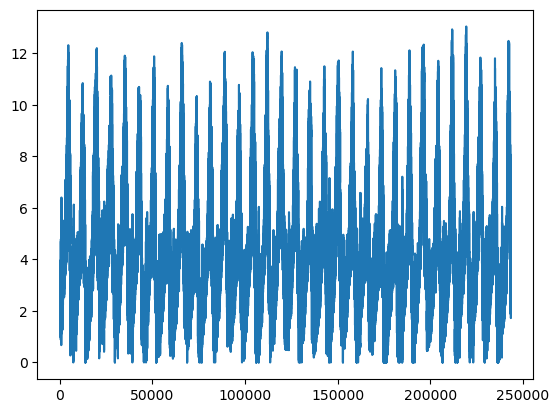

In [51]:
import matplotlib.pyplot as plt

plt.plot(cur_preds['prd.stream_temp'])

In [52]:
cur_preds['prd.stream_temp'].max()

np.float64(13.0339194772221)

In [53]:
cur_preds['prd.stream_temp'].min()

np.float64(0.0)

In [54]:
cur_preds['prd.stream_temp'].median()

np.float64(3.33484523900518)

In [17]:
cur_output = (f'DATA/gpkgs/{huc}.gpkg')

In [18]:
cur_output

'DATA/gpkgs/1702000720.gpkg'

In [24]:
cur_comids_preds = preds_flat.COMID.unique()
len(cur_comids_preds)

42

In [25]:
%load_ext rpy2.ipython

In [26]:
%%R
install.packages("fst")

R[write to console]: Installing package into ‘/Users/dawn.urycki/Library/R/x86_64/4.3/library’
(as ‘lib’ is unspecified)



--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Guangzhou) [https]
20: China (Jinan) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Marseille

Selection:  70


R[write to console]: trying URL 'https://ftp.osuosl.org/pub/cran/src/contrib/fst_0.9.8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 274495 bytes (268 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/opt/miniconda3/envs/temp-data-env/lib/R/include" -DNDEBUG  -I'/Users/dawn.urycki/Library/R/x86_64/4.3/library/Rcpp/include' -I'/Users/dawn.urycki/Library/R/x86_64/4.3/library/fstcore/include' -D_FORTIFY_SOURCE=2 -isystem /opt/miniconda3/envs/temp-data-env/include -mmacosx-version-min=10.13 -mmacosx-version-min=10.13 -I/opt/miniconda3/envs/temp-data-env/include    -fPIC  -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -stdlib=libc++ -fvisibility-inlines-hidden -fmessage-length=0 -isystem /opt/miniconda3/envs/temp-data-env/include -fdebug-prefix-map=/Users/runner/miniforge3/conda-bld/r-base-split_1728291276454/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/miniconda3/envs/temp-data-env=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/opt/miniconda3/envs/temp-data-env/lib/R/include" -DNDEBUG  -I'/Users/dawn.uryc

installing to /Users/dawn.urycki/Library/R/x86_64/4.3/library/00LOCK-fst/00new/fst/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fst)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/private/var/folders/95/99dy_ns968195cnlvp5xhwqm0000gp/T/RtmpwLQFqs/downloaded_packages’
R[write to console]: 
R[write to console]: 



In [29]:
%%R
library(fst)
getwd()

[1] "/Users/dawn.urycki/Repos/temp-data"


In [30]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [32]:
%%time
df = ro.r(f"read.fst('DATA/temp_cov_huc_1702000720.fst')")
df.head()

CPU times: user 9.64 s, sys: 2.21 s, total: 11.9 s
Wall time: 4.66 s


,lookup,COMID,cov.air_temp,cov.air_temp_ws,cov.air_temp_3d,cov.air_temp_6d,cov.air_temp_9d,cov.air_temp_12d,cov.air_temp_15d,cov.air_temp_18d,...,tim.date,cov.SWE,cov.SWE_ws,cov.NWM_flow,cov.NWM_flow_log,cov.daylength,cov.daylength_hours,cov.SWE_mean_year,cov.SWE_1Apr,cov.SWE_last_doy
1,23065579_1990_1,23065579,-1.991000,-1.991000,NaN,NaN,NaN,NaN,NaN,NaN,...,7306.0,17.0,17.0,0.00001,-11.512925,29030.4,8.064,9.123288,0.0,169.0
2,23065579_1990_10,23065579,1.026000,1.026000,2.291000,0.945667,-0.786667,NaN,NaN,NaN,...,7315.0,25.0,25.0,0.00001,-11.512925,30067.2,8.352,9.123288,0.0,169.0
3,23065579_1990_100,23065579,6.658000,6.658000,9.664000,10.267834,10.465778,10.382167,9.722800,8.274000,...,7405.0,0.0,0.0,0.01000,-4.605170,47347.2,13.152,9.123288,0.0,169.0
4,23065579_1990_101,23065579,7.245000,7.245000,7.912667,9.778667,9.962223,10.247250,9.800200,8.697945,...,7406.0,0.0,0.0,0.01000,-4.605170,47692.8,13.248,9.123288,0.0,169.0
5,23065579_1990_102,23065579,8.252001,8.252001,7.385001,9.352167,9.568445,10.108500,9.824334,9.100612,...,7407.0,0.0,0.0,0.01000,-4.605170,47692.8,13.248,9.123288,0.0,169.0


In [38]:
df.tail()

,lookup,COMID,cov.air_temp,cov.air_temp_ws,cov.air_temp_3d,cov.air_temp_6d,cov.air_temp_9d,cov.air_temp_12d,cov.air_temp_15d,cov.air_temp_18d,...,tim.date,cov.SWE,cov.SWE_ws,cov.NWM_flow,cov.NWM_flow_log,cov.daylength,cov.daylength_hours,cov.SWE_mean_year,cov.SWE_1Apr,cov.SWE_last_doy
879865,24961737_2022_95,24961737,1.5048,1.5048,3.237633,3.112833,4.702578,4.772358,4.446227,3.858122,...,19088.0,NaN,NaN,0.00001,-11.512925,46310.4,12.864,NaN,NaN,NaN
879866,24961737_2022_96,24961737,2.0464,2.0464,2.468167,2.798600,3.893344,4.730658,4.537620,3.822678,...,19089.0,NaN,NaN,0.00001,-11.512925,46656.0,12.960,NaN,NaN,NaN
879867,24961737_2022_97,24961737,2.1493,2.1493,1.900167,2.755983,3.290733,4.446558,4.417300,3.920683,...,19090.0,NaN,NaN,0.00001,-11.512925,46656.0,12.960,NaN,NaN,NaN
879868,24961737_2022_98,24961737,6.7946,6.7946,3.663433,3.450533,3.296367,4.442792,4.550573,4.315761,...,19091.0,NaN,NaN,0.00001,-11.512925,47001.6,13.056,NaN,NaN,NaN
879869,24961737_2022_99,24961737,5.0340,5.0340,4.659300,3.563733,3.418833,4.084833,4.716387,4.557900,...,19092.0,NaN,NaN,0.00001,-11.512925,47347.2,13.152,NaN,NaN,NaN


In [36]:
cur_spatial_data = spatial_data_fill.loc[cur_comids_preds]
len(cur_spatial_data)

42

In [37]:
cur_spatial_data.head()

,cov.length_km,cov.stream_order,cov.path_length,cov.tot.da.sqkm,cov.elev_max_smo,cov.elev_min_smo,cov.slope,cov.sinuosity,cov.lat_v,cov.elev_mean_smo,...,cov.canopy_rca,cov.canopy_line,cov.area_sqkm,cov.canopy_ws,cov.dam_name,cov.proportion_dam_influenced,cov.distance_below_dam,cov.dam_hgt_m,cov.dam_main_use,geometry
COMID,,,,,,,,,,,,,,,,,,,,,
23066771,2.724,6.0,968.491,9253.2636,27630.0,27621.0,0.000033,2.49,48.908100,276.255,...,69.0,60.0,1.7352,74.129544,ENLOE DAM,0.994167,11.094,16.0,Hydroelectricity,"LINESTRING Z (-119.43344 48.91756 0, -119.4336..."
23066773,2.166,6.0,972.198,9243.9198,27959.0,27724.0,0.001085,1.06,48.930301,278.415,...,68.0,64.5,1.9413,74.161480,ENLOE DAM,0.995172,7.387,16.0,Hydroelectricity,"LINESTRING Z (-119.44774 48.93961 0, -119.4457..."
23066775,0.317,6.0,974.364,9240.2217,28013.0,27959.0,0.001703,1.00,48.936500,279.860,...,71.5,69.0,3.0618,74.175709,ENLOE DAM,0.995571,5.221,16.0,Hydroelectricity,"LINESTRING Z (-119.4506 48.94175 0, -119.44774..."
23067095,0.524,6.0,971.674,9244.3338,27724.0,27655.0,0.001317,1.22,48.920101,276.895,...,64.5,60.0,1.3131,74.158989,ENLOE DAM,0.995128,7.911,16.0,Hydroelectricity,"LINESTRING Z (-119.44245 48.92137 0, -119.4421..."
23067097,0.459,6.0,971.215,9244.4967,27655.0,27630.0,0.000545,1.22,48.921600,276.425,...,60.0,60.0,1.1565,74.157552,ENLOE DAM,0.995110,8.370,16.0,Hydroelectricity,"LINESTRING Z (-119.43706 48.91995 0, -119.4365..."


In [28]:
%%time
gpd.GeoDataFrame(cur_spatial_data).to_file(cur_output, layer = 'spatial_covariates', driver = "GPKG", layer_metadata = {'Fill value' : '-9999'}, dataset_metadata = nc_metadata)

CPU times: user 28.4 ms, sys: 10.9 ms, total: 39.4 ms
Wall time: 53.1 ms


In [78]:
#pyogrio.list_layers(cur_output)

In [79]:
#pyogrio.list_layers(cur_output)

In [80]:
#pyogrio.read_info(cur_output)

In [81]:
#test_gdf = gpd.read_file(cur_output)

In [82]:
#test_gdf

In [34]:
#test_gdf.explore()

In [83]:
%%time
#gpd.GeoDataFrame(preds_flat).to_file(cur_output, layer = 'stream_temperature_predictions', driver = "GPKG", layer_metadata = {'Fill_value' : '-9999'})

CPU times: user 4 μs, sys: 2 μs, total: 6 μs
Wall time: 8.82 μs


In [84]:
#pyogrio.read_info(cur_output)

In [37]:
# Now add temporal covariates


In [38]:
# Now add spatial covariates metadata
gpd.GeoDataFrame(covariate_metadata).to_file(cur_output, layer = 'covariate_metadata', driver = "GPKG")

In [39]:
# Now add GCM metadata
gpd.GeoDataFrame(gcm_metadata).to_file(cur_output, layer = 'GCM_metadata', driver = "GPKG")

In [85]:
#pyogrio.list_layers(cur_output)

In [86]:
#pyogrio.read_info(cur_output, layer = 'GCM_metadata')

In [42]:
huc

1702000720

In [48]:
gcms

['CanESM2',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'GDFL-ESM2M',
 'HadGEM-CC365',
 'HadGEM2-ES',
 'inmcm4',
 'IPSL-CM5A-MR',
 'MIROC5']

In [49]:
cur_gcm = gcms[0]

In [92]:
%%time
for cur_gcm in [gcms[0]]: 
    try:
        print(cur_gcm)
        cur_df = ro.r(f"read.fst('DATA/{cur_gcm}/huc_{huc}.fst')")
        cur_df_fill = cur_df.fillna(-9999)
        #gpd.GeoDataFrame(cur_df_fill).to_file(cur_output, layer = f'temporal_covariates_{cur_gcm}', driver = "GPKG", layer_metadata = {'Fill value': '-9999'})
    except: pass

CanESM2
CPU times: user 51.4 s, sys: 6.78 s, total: 58.2 s
Wall time: 49.1 s


In [94]:
CanESM2_df = cur_df.copy()

In [103]:
CanESM2_df.head()

,COMID,SegID,lookup,cov.air_temp,cov.air_temp_ws,cov.air_temp_3d,cov.air_temp_6d,cov.air_temp_9d,cov.air_temp_12d,cov.air_temp_15d,...,cov.Flow,cov.Flow_log,tim.year,tim.doy,tim.date,cov.daylength,cov.daylength_hours,cov.SWE_mean_year,cov.SWE_1Apr,cov.SWE_last_doy
1,24120706,4126,4126_1950_1,-16.526405,-21.096784,NaN,NaN,NaN,NaN,NaN,...,0.212842,-1.547207,1950.0,1.0,-7305.0,29030.4,8.064,61.418016,139.427406,365.0
2,24120706,4126,4126_1950_10,-11.314290,-16.989374,-8.728696,-12.190027,-9.953042,NaN,NaN,...,0.398822,-0.919239,1950.0,10.0,-7296.0,30067.2,8.352,61.418016,139.427406,365.0
3,24120706,4126,4126_1950_100,4.793318,0.504388,4.170258,7.144744,5.998789,5.943844,5.511841,...,1.051988,0.050682,1950.0,100.0,-7206.0,47347.2,13.152,61.418016,139.427406,365.0
4,24120706,4126,4126_1950_101,5.475709,2.091127,4.732936,6.402701,6.336809,5.980180,5.563224,...,1.153476,0.142780,1950.0,101.0,-7205.0,47692.8,13.248,61.418016,139.427406,365.0
5,24120706,4126,4126_1950_102,7.709150,3.441271,5.992725,5.572593,6.789519,6.092021,5.865226,...,1.340546,0.293077,1950.0,102.0,-7204.0,47692.8,13.248,61.418016,139.427406,365.0


In [ ]:
gcm

In [102]:
CanESM2_df['tim.date']

1          -7305.0
2          -7296.0
3          -7206.0
4          -7205.0
5          -7204.0
            ...   
2629772    47214.0
2629773    47215.0
2629774    47215.0
2629775    47215.0
2629776    47215.0
Name: tim.date, Length: 2629776, dtype: float64

In [96]:
len_CanESM2 = len(CanESM2_df)

In [87]:
#pyogrio.list_layers(cur_output)

In [88]:
#pyogrio.read_info(cur_output, layer = 'temporal_covariates_CanESM2')

In [89]:
#cur_df_fill.head

In [90]:
%%time
#gpd.GeoDataFrame(df_fill).to_file(cur_output, layer = f'temporal_covariates_{cur_gcm}', driver = "GPKG", layer_metadata = {'Fill value': '-9999'})

CPU times: user 5 μs, sys: 2 μs, total: 7 μs
Wall time: 14.1 μs


In [52]:
cur_output

'DATA/gpkgs/1702000720.gpkg'

In [55]:
df_all_gcm

,lookup,COMID,cov.air_temp,cov.air_temp_ws,cov.air_temp_3d,cov.air_temp_6d,cov.air_temp_9d,cov.air_temp_12d,cov.air_temp_15d,cov.air_temp_18d,...,tim.date,cov.SWE,cov.SWE_ws,cov.NWM_flow,cov.NWM_flow_log,cov.daylength,cov.daylength_hours,cov.SWE_mean_year,cov.SWE_1Apr,cov.SWE_last_doy
1,23065579_1990_1,23065579,-1.991000,-1.991000,NaN,NaN,NaN,NaN,NaN,NaN,...,7306.0,17.0,17.0,0.00001,-11.512925,29030.4,8.064,9.123288,0.0,169.0
2,23065579_1990_10,23065579,1.026000,1.026000,2.291000,0.945667,-0.786667,NaN,NaN,NaN,...,7315.0,25.0,25.0,0.00001,-11.512925,30067.2,8.352,9.123288,0.0,169.0
3,23065579_1990_100,23065579,6.658000,6.658000,9.664000,10.267834,10.465778,10.382167,9.722800,8.274000,...,7405.0,0.0,0.0,0.01000,-4.605170,47347.2,13.152,9.123288,0.0,169.0
4,23065579_1990_101,23065579,7.245000,7.245000,7.912667,9.778667,9.962223,10.247250,9.800200,8.697945,...,7406.0,0.0,0.0,0.01000,-4.605170,47692.8,13.248,9.123288,0.0,169.0
5,23065579_1990_102,23065579,8.252001,8.252001,7.385001,9.352167,9.568445,10.108500,9.824334,9.100612,...,7407.0,0.0,0.0,0.01000,-4.605170,47692.8,13.248,9.123288,0.0,169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879865,24961737_2022_95,24961737,1.504800,1.504800,3.237633,3.112833,4.702578,4.772358,4.446227,3.858122,...,19088.0,NaN,NaN,0.00001,-11.512925,46310.4,12.864,NaN,NaN,NaN
879866,24961737_2022_96,24961737,2.046400,2.046400,2.468167,2.798600,3.893344,4.730658,4.537620,3.822678,...,19089.0,NaN,NaN,0.00001,-11.512925,46656.0,12.960,NaN,NaN,NaN
879867,24961737_2022_97,24961737,2.149300,2.149300,1.900167,2.755983,3.290733,4.446558,4.417300,3.920683,...,19090.0,NaN,NaN,0.00001,-11.512925,46656.0,12.960,NaN,NaN,NaN
879868,24961737_2022_98,24961737,6.794600,6.794600,3.663433,3.450533,3.296367,4.442792,4.550573,4.315761,...,19091.0,NaN,NaN,0.00001,-11.512925,47001.6,13.056,NaN,NaN,NaN


In [104]:
df_all_gcm.columns

Index(['lookup', 'COMID', 'cov.air_temp', 'cov.air_temp_ws', 'cov.air_temp_3d',
       'cov.air_temp_6d', 'cov.air_temp_9d', 'cov.air_temp_12d',
       'cov.air_temp_15d', 'cov.air_temp_18d', 'cov.air_temp_21d',
       'cov.air_temp_24d', 'cov.air_temp_27d', 'cov.air_temp_30d',
       'cov.air_temp_35d', 'cov.air_temp_40d', 'cov.air_temp_50d',
       'cov.air_temp_60d', 'Huc10', 'tim.year', 'tim.doy', 'tim.date',
       'cov.SWE', 'cov.SWE_ws', 'cov.NWM_flow', 'cov.NWM_flow_log',
       'cov.daylength', 'cov.daylength_hours', 'cov.SWE_mean_year',
       'cov.SWE_1Apr', 'cov.SWE_last_doy'],
      dtype='object')

In [66]:
df_fill

,lookup,COMID,cov.air_temp,cov.air_temp_ws,cov.air_temp_3d,cov.air_temp_6d,cov.air_temp_9d,cov.air_temp_12d,cov.air_temp_15d,cov.air_temp_18d,...,tim.date,cov.SWE,cov.SWE_ws,cov.NWM_flow,cov.NWM_flow_log,cov.daylength,cov.daylength_hours,cov.SWE_mean_year,cov.SWE_1Apr,cov.SWE_last_doy
1,23065579_1990_1,23065579,-1.991000,-1.991000,NaN,NaN,NaN,NaN,NaN,NaN,...,7306.0,17.0,17.0,0.00001,-11.512925,29030.4,8.064,9.123288,0.0,169.0
2,23065579_1990_10,23065579,1.026000,1.026000,2.291000,0.945667,-0.786667,NaN,NaN,NaN,...,7315.0,25.0,25.0,0.00001,-11.512925,30067.2,8.352,9.123288,0.0,169.0
3,23065579_1990_100,23065579,6.658000,6.658000,9.664000,10.267834,10.465778,10.382167,9.722800,8.274000,...,7405.0,0.0,0.0,0.01000,-4.605170,47347.2,13.152,9.123288,0.0,169.0
4,23065579_1990_101,23065579,7.245000,7.245000,7.912667,9.778667,9.962223,10.247250,9.800200,8.697945,...,7406.0,0.0,0.0,0.01000,-4.605170,47692.8,13.248,9.123288,0.0,169.0
5,23065579_1990_102,23065579,8.252001,8.252001,7.385001,9.352167,9.568445,10.108500,9.824334,9.100612,...,7407.0,0.0,0.0,0.01000,-4.605170,47692.8,13.248,9.123288,0.0,169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879865,24961737_2022_95,24961737,1.504800,1.504800,3.237633,3.112833,4.702578,4.772358,4.446227,3.858122,...,19088.0,NaN,NaN,0.00001,-11.512925,46310.4,12.864,NaN,NaN,NaN
879866,24961737_2022_96,24961737,2.046400,2.046400,2.468167,2.798600,3.893344,4.730658,4.537620,3.822678,...,19089.0,NaN,NaN,0.00001,-11.512925,46656.0,12.960,NaN,NaN,NaN
879867,24961737_2022_97,24961737,2.149300,2.149300,1.900167,2.755983,3.290733,4.446558,4.417300,3.920683,...,19090.0,NaN,NaN,0.00001,-11.512925,46656.0,12.960,NaN,NaN,NaN
879868,24961737_2022_98,24961737,6.794600,6.794600,3.663433,3.450533,3.296367,4.442792,4.550573,4.315761,...,19091.0,NaN,NaN,0.00001,-11.512925,47001.6,13.056,NaN,NaN,NaN


In [69]:
df_fill_set = set(df_fill.COMID.unique())

In [70]:
df_fill_set

{np.int64(23066771),
 np.int64(23066773),
 np.int64(23066775),
 np.int64(23067095),
 np.int64(23067097),
 np.int64(23067181),
 np.int64(24120666),
 np.int64(24120668),
 np.int64(24120670),
 np.int64(24120672),
 np.int64(24120674),
 np.int64(24120676),
 np.int64(24120678),
 np.int64(24120680),
 np.int64(24120682),
 np.int64(24120684),
 np.int64(24120686),
 np.int64(24120688),
 np.int64(24120690),
 np.int64(24120692),
 np.int64(24120694),
 np.int64(24120696),
 np.int64(24120698),
 np.int64(24120700),
 np.int64(24120704),
 np.int64(24120706),
 np.int64(24120708),
 np.int64(24120710),
 np.int64(24120712),
 np.int64(24120714),
 np.int64(24120716),
 np.int64(24120718),
 np.int64(24120738),
 np.int64(24121446),
 np.int64(24121550),
 np.int64(24121932),
 np.int64(24121936),
 np.int64(24121938),
 np.int64(24121946),
 np.int64(24121948),
 np.int64(24121950),
 np.int64(24121952),
 np.int64(24121954),
 np.int64(24121956),
 np.int64(24121962),
 np.int64(24121964),
 np.int64(24121984),
 np.int64(241

In [71]:
df_set = set(df.COMID.unique())

In [72]:
df_set

{np.int64(23065579),
 np.int64(23066771),
 np.int64(23066773),
 np.int64(23066775),
 np.int64(23066855),
 np.int64(23067095),
 np.int64(23067097),
 np.int64(23067177),
 np.int64(23067179),
 np.int64(23067181),
 np.int64(24120666),
 np.int64(24120668),
 np.int64(24120670),
 np.int64(24120672),
 np.int64(24120674),
 np.int64(24120676),
 np.int64(24120678),
 np.int64(24120680),
 np.int64(24120682),
 np.int64(24120684),
 np.int64(24120686),
 np.int64(24120688),
 np.int64(24120690),
 np.int64(24120692),
 np.int64(24120694),
 np.int64(24120696),
 np.int64(24120698),
 np.int64(24120700),
 np.int64(24120704),
 np.int64(24120706),
 np.int64(24120708),
 np.int64(24120710),
 np.int64(24120712),
 np.int64(24120714),
 np.int64(24120716),
 np.int64(24121480),
 np.int64(24121484),
 np.int64(24121492),
 np.int64(24121510),
 np.int64(24121528),
 np.int64(24121540),
 np.int64(24121542),
 np.int64(24121544),
 np.int64(24121548),
 np.int64(24121550),
 np.int64(24121552),
 np.int64(24121570),
 np.int64(241

In [74]:
df_fill_set.difference(df_set)

{np.int64(24120718),
 np.int64(24120738),
 np.int64(24121446),
 np.int64(24121946),
 np.int64(24121948),
 np.int64(24121956),
 np.int64(24121962),
 np.int64(24121990)}

In [76]:
spatial_data_all


,COMID,cov.length_km,cov.stream_order,cov.path_length,cov.tot.da.sqkm,cov.elev_max_smo,cov.elev_min_smo,cov.slope,cov.sinuosity,cov.lat_v,...,cov.pct_urb_all_ws,cov.canopy_rca,cov.canopy_line,cov.area_sqkm,cov.canopy_ws,cov.dam_name,cov.proportion_dam_influenced,cov.distance_below_dam,cov.dam_hgt_m,cov.dam_main_use
0,9301535,0.999,NaN,NaN,NaN,NaN,NaN,NaN,1.47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22226592,0.733,NaN,NaN,NaN,NaN,NaN,NaN,1.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22226600,6.117,NaN,NaN,NaN,NaN,NaN,NaN,1.62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22877591,0.247,6.0,1290.195,28030.5369,56102.0,55932.0,0.006883,1.00,48.558399,...,0.946698,89.000000,90.0,1.9161,88.592748,Libby,0.831332,71.294,129.0,Hydroelectricity
4,22877593,0.055,3.0,1290.442,58.4136,56129.0,56102.0,0.004909,1.00,48.556999,...,0.000000,90.000000,90.0,0.4284,90.227047,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270936,947120097,0.161,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270937,947120098,1.218,2.0,40.722,10.9971,145858.0,139672.0,0.050788,1.04,42.388000,...,0.000000,82.333333,82.0,0.4815,82.684671,NaN,NaN,NaN,NaN,NaN
270938,947120099,0.366,NaN,NaN,NaN,NaN,NaN,NaN,1.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270939,947120100,2.893,3.0,39.940,44.0622,140135.0,138629.0,0.005206,1.12,42.368198,...,0.449365,81.000000,78.0,0.2196,80.865589,NaN,NaN,NaN,NaN,NaN


In [77]:
cur_spatial_data

,cov.length_km,cov.stream_order,cov.path_length,cov.tot.da.sqkm,cov.elev_max_smo,cov.elev_min_smo,cov.slope,cov.sinuosity,cov.lat_v,cov.elev_mean_smo,...,cov.canopy_rca,cov.canopy_line,cov.area_sqkm,cov.canopy_ws,cov.dam_name,cov.proportion_dam_influenced,cov.distance_below_dam,cov.dam_hgt_m,cov.dam_main_use,geometry
COMID,,,,,,,,,,,,,,,,,,,,,
23066771,2.724,6.0,968.491,9253.2636,27630.0,27621.0,0.000033,2.49,48.908100,276.255,...,69.000000,60.000000,1.7352,74.129544,ENLOE DAM,0.994167,11.094,16.0,Hydroelectricity,"LINESTRING Z (-119.43344 48.91756 0, -119.4336..."
23066773,2.166,6.0,972.198,9243.9198,27959.0,27724.0,0.001085,1.06,48.930301,278.415,...,68.000000,64.500000,1.9413,74.161480,ENLOE DAM,0.995172,7.387,16.0,Hydroelectricity,"LINESTRING Z (-119.44774 48.93961 0, -119.4457..."
23066775,0.317,6.0,974.364,9240.2217,28013.0,27959.0,0.001703,1.00,48.936500,279.860,...,71.500000,69.000000,3.0618,74.175709,ENLOE DAM,0.995571,5.221,16.0,Hydroelectricity,"LINESTRING Z (-119.4506 48.94175 0, -119.44774..."
23067095,0.524,6.0,971.674,9244.3338,27724.0,27655.0,0.001317,1.22,48.920101,276.895,...,64.500000,60.000000,1.3131,74.158989,ENLOE DAM,0.995128,7.911,16.0,Hydroelectricity,"LINESTRING Z (-119.44245 48.92137 0, -119.4421..."
23067097,0.459,6.0,971.215,9244.4967,27655.0,27630.0,0.000545,1.22,48.921600,276.425,...,60.000000,60.000000,1.1565,74.157552,ENLOE DAM,0.995110,8.370,16.0,Hydroelectricity,"LINESTRING Z (-119.43706 48.91995 0, -119.4365..."
23067181,1.941,6.0,965.317,9256.0887,27620.0,27620.0,0.000010,2.81,48.895198,276.200,...,68.333333,63.000000,1.0926,74.117784,ENLOE DAM,0.993864,14.268,16.0,Hydroelectricity,"LINESTRING Z (-119.43337 48.89747 0, -119.4335..."
24120666,3.146,6.0,974.681,9239.3883,28964.0,28013.0,0.003023,1.09,48.951099,284.885,...,74.000000,69.000000,7.1703,74.177102,ENLOE DAM,0.995660,4.904,16.0,Hydroelectricity,"LINESTRING Z (-119.48537 48.95368 0, -119.4848..."
24120668,0.742,6.0,977.827,9227.2221,29291.0,28964.0,0.004407,1.03,48.954200,291.275,...,71.500000,64.000000,2.0295,74.181981,ENLOE DAM,0.996973,1.758,16.0,Hydroelectricity,"LINESTRING Z (-119.49154 48.95875 0, -119.4884..."
24120670,0.757,6.0,978.569,9224.4483,30194.0,29291.0,0.011929,1.01,48.959201,297.425,...,67.500000,64.000000,1.4202,74.194093,ENLOE DAM,0.997273,1.016,16.0,Hydroelectricity,"LINESTRING Z (-119.4996 48.96282 0, -119.49797..."


In [78]:
len(cur_spatial_data)

42

In [79]:
len(df_fill_set)

48

In [80]:
len(df_set)

73

In [50]:
huc

1702000720

In [ ]:
gcm1 = 

In [240]:
gcm = 'GDFL-ESM2M'

In [31]:
def get_geometries(comids, hydrofile):
    flowlines_all = gpd.read_file(hydrofile)
    geometries = flowlines_all[['COMID', 'geometry']].set_index('COMID')
    return geometries

In [ ]:
def add_attribute_table(df, gpkg, layer_name = 'stream_temperature_predictions'):
    df["geometry"] = [None for i in df.index]
    attonly_schema = {"geometry": "None", "properties": df.dtypes.to_dict()}
    df.to_file(gpkg, layer = layer_name, driver = "GPKG", schema = attonly_schema)
    return None

In [49]:
df = gpd.GeoDataFrame(preds_flat)

In [50]:
df["geometry"] = [None for i in df.index]

In [51]:
attonly_schema = {"geometry": "None", "properties": df.dtypes.to_dict()}

In [52]:
gpkg = 'test_output.gpkg'

In [54]:
layer_name = 'stream_temperature_predictions'

In [58]:
%%time
gpd.GeoDataFrame(preds_flat).to_file(gpkg, layer = layer_name, driver = "GPKG")

/opt/miniconda3/envs/temp-data-env/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


CPU times: user 2min 8s, sys: 4.06 s, total: 2min 12s
Wall time: 2min 12s


In [59]:
gpd.read_file(cur)

/opt/miniconda3/envs/temp-data-env/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'test_output.gpkg': 'test_output' (default), 'stream_temperature_predictions'. Specify layer parameter to avoid this warning.
  result = read_func(


,COMID,geometry
0,23066771,"LINESTRING Z (-119.43344 48.91756 0, -119.4336..."
1,23066773,"LINESTRING Z (-119.44774 48.93961 0, -119.4457..."
2,23066775,"LINESTRING Z (-119.4506 48.94175 0, -119.44774..."
3,23067095,"LINESTRING Z (-119.44245 48.92137 0, -119.4421..."
4,23067097,"LINESTRING Z (-119.43706 48.91995 0, -119.4365..."
5,23067181,"LINESTRING Z (-119.43337 48.89747 0, -119.4335..."
6,24120666,"LINESTRING Z (-119.48537 48.95368 0, -119.4848..."
7,24120668,"LINESTRING Z (-119.49154 48.95875 0, -119.4884..."
8,24120670,"LINESTRING Z (-119.4996 48.96282 0, -119.49797..."
9,24120672,"LINESTRING Z (-119.50067 48.96447 0, -119.5005..."


In [60]:
gpd.read_file(gpkg, layer = 'stream_temperature_predictions')

,COMID,GCM,date,prd.stream_temp,geometry
0,23066771,CanESM2,1950-01-01,NaN,None
1,23066771,CanESM2,1950-01-02,NaN,None
2,23066771,CanESM2,1950-01-03,NaN,None
3,23066771,CanESM2,1950-01-04,NaN,None
4,23066771,CanESM2,1950-01-05,NaN,None
...,...,...,...,...,...
23010535,24121984,MIROC5,2099-12-27,9.303043,None
23010536,24121984,MIROC5,2099-12-28,8.525719,None
23010537,24121984,MIROC5,2099-12-29,7.030612,None
23010538,24121984,MIROC5,2099-12-30,8.553759,None


In [61]:
gpd.list_layers(gpkg)

,name,geometry_type
0,test_output,LineString Z
1,stream_temperature_predictions,Unknown


In [65]:
import pyogrio


In [66]:
pyogrio.list_layers(gpkg)

array([['test_output', 'LineString Z'],
       ['stream_temperature_predictions', 'Unknown']], dtype=object)

In [67]:
pyogrio.read_info(gpkg)

/var/folders/95/99dy_ns968195cnlvp5xhwqm0000gp/T/ipykernel_15013/214239797.py:1: UserWarning: More than one layer found in 'test_output.gpkg': 'test_output' (default), 'stream_temperature_predictions'. Specify layer parameter to avoid this warning.
  pyogrio.read_info(gpkg)


{'layer_name': 'test_output',
 'crs': 'EPSG:4269',
 'encoding': 'UTF-8',
 'fields': array(['COMID'], dtype=object),
 'dtypes': array(['int32'], dtype=object),
 'fid_column': 'fid',
 'geometry_name': 'geom',
 'geometry_type': 'LineString Z',
 'features': 42,
 'total_bounds': (-119.709822791293,
  48.8388943241923,
  -119.429657325061,
  48.9890991906258),
 'driver': 'GPKG',
 'capabilities': {'random_read': True,
  'fast_set_next_by_index': True,
  'fast_spatial_filter': True,
  'fast_feature_count': True,
  'fast_total_bounds': True},
 'layer_metadata': None,
 'dataset_metadata': None}

In [32]:
# Load nc dataset 

def nc_to_gpkg(nc_filename, shortname_dict, dims = ['COMID', 'GCM', 'date']):
    preds = xr.open_dataset(cur_ncfile)
    predsdf = preds.to_dataframe(dim_order = dims)
    preds_flat = predsdf.reset_index()
    preds_flat.GCM = preds_flat.GCM.map(shortname_dict)

    # Retrieve geometries
    cur_comids = predsdf.index.get_level_values('COMID').unique()
    geoms = get_geometries(cur_comids, dbfhydro[0])

    # Create geopackage
    cur_geom.to_file('test_output.gpkg', driver = "GPKG")
    
    
    

In [42]:
preds_flat.dtypes.to_dict()

{'COMID': dtype('int32'),
 'GCM': dtype('O'),
 'date': dtype('<M8[ns]'),
 'prd.stream_temp': dtype('float64')}

In [17]:
gcm_metadata = 

In [18]:
gcms = gcm_metadata['Global Climate Model short name'].to_list()

In [19]:
gcms

['CanESM2',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'GDFL-ESM2M',
 'HadGEM-CC365',
 'HadGEM2-ES',
 'inmcm4',
 'IPSL-CM5A-MR',
 'MIROC5']

In [20]:
gcm_dict = {i+1:gcms[i] for i in list(range(10))}
gcm_dict

{1: 'CanESM2',
 2: 'CCSM4',
 3: 'CNRM-CM5',
 4: 'CSIRO-Mk3-6-0',
 5: 'GDFL-ESM2M',
 6: 'HadGEM-CC365',
 7: 'HadGEM2-ES',
 8: 'inmcm4',
 9: 'IPSL-CM5A-MR',
 10: 'MIROC5'}

In [15]:
150*365


54750

In [21]:
#conda install fstlib

In [22]:
#pip install fstlib


In [23]:
#from fstlib import fstlib

In [24]:
predsdf

prd.stream_temp
COMID    GCM date                       
23066771 1   1950-01-01              NaN
             1950-01-02              NaN
             1950-01-03              NaN
             1950-01-04              NaN
             1950-01-05              NaN
...                                  ...
24121984 10  2099-12-27         9.303043
             2099-12-28         8.525719
             2099-12-29         7.030612
             2099-12-30         8.553759
             2099-12-31         7.153554

[23010540 rows x 1 columns]

In [ ]:
predsdf

In [26]:
cur_comids = predsdf.index.get_level_values('COMID').unique()

In [27]:
len(predsdf.index.get_level_values('COMID').unique())

42

In [28]:
cur_comids

Index([23066771, 23066773, 23066775, 23067095, 23067097, 23067181, 24120666,
       24120668, 24120670, 24120672, 24120674, 24120676, 24120678, 24120680,
       24120682, 24120684, 24120686, 24120688, 24120690, 24120692, 24120694,
       24120696, 24120698, 24120700, 24120704, 24120706, 24120708, 24120710,
       24120712, 24120714, 24120716, 24120718, 24120738, 24121550, 24121932,
       24121936, 24121938, 24121950, 24121952, 24121954, 24121964, 24121984],
      dtype='int32', name='COMID')

In [18]:
#gcm1 = predsdf.xs(1, level = 1)

In [19]:
#gcm1

prd.stream_temp
COMID    date                       
23066771 1950-01-01              NaN
         1950-01-02              NaN
         1950-01-03              NaN
         1950-01-04              NaN
         1950-01-05              NaN
...                              ...
24121984 2099-12-27         5.770917
         2099-12-28         6.822931
         2099-12-29         7.623787
         2099-12-30         8.221618
         2099-12-31         7.753777

[2301054 rows x 1 columns]

In [41]:
import pandas as pd

In [64]:
geometries = flowlines_all[['COMID', 'geometry']].set_index('COMID')
geometries


,geometry
COMID,
9301535,"LINESTRING Z (-114.05855 48.99999 0, -114.0583..."
22968128,"LINESTRING Z (-113.00089 47.46274 0, -113.0020..."
22968138,"LINESTRING Z (-113.0013 47.45837 0, -113.00137..."
23135995,"LINESTRING Z (-111.06214 42.50841 0, -111.0619..."
23135997,"LINESTRING Z (-111.04516 42.51372 0, -111.0447..."
...,...
24545039,"LINESTRING Z (-118.12671 42.98327 0, -118.1260..."
24545041,"LINESTRING Z (-118.1111 42.99525 0, -118.11175..."
23706720,"LINESTRING Z (-121.60348 43.32724 0, -121.6034..."


In [43]:
#gcm1.index.get_level_values(0)

Index([23066771, 23066771, 23066771, 23066771, 23066771, 23066771, 23066771,
       23066771, 23066771, 23066771,
       ...
       24121984, 24121984, 24121984, 24121984, 24121984, 24121984, 24121984,
       24121984, 24121984, 24121984],
      dtype='int32', name='COMID', length=2301054)

In [21]:
#gcm1_flat = gcm1.reset_index()

In [22]:
#gcm1_flat


,COMID,date,prd.stream_temp
0,23066771,1950-01-01,NaN
1,23066771,1950-01-02,NaN
2,23066771,1950-01-03,NaN
3,23066771,1950-01-04,NaN
4,23066771,1950-01-05,NaN
...,...,...,...
2301049,24121984,2099-12-27,5.770917
2301050,24121984,2099-12-28,6.822931
2301051,24121984,2099-12-29,7.623787
2301052,24121984,2099-12-30,8.221618


In [66]:
preds_flat = predsdf.reset_index()
preds_flat

,COMID,GCM,date,prd.stream_temp
0,23066771,1,1950-01-01,NaN
1,23066771,1,1950-01-02,NaN
2,23066771,1,1950-01-03,NaN
3,23066771,1,1950-01-04,NaN
4,23066771,1,1950-01-05,NaN
...,...,...,...,...
23010535,24121984,10,2099-12-27,9.303043
23010536,24121984,10,2099-12-28,8.525719
23010537,24121984,10,2099-12-29,7.030612
23010538,24121984,10,2099-12-30,8.553759


In [73]:
cur_comids = preds_flat.COMID.unique()
cur_comids

array([23066771, 23066773, 23066775, 23067095, 23067097, 23067181,
       24120666, 24120668, 24120670, 24120672, 24120674, 24120676,
       24120678, 24120680, 24120682, 24120684, 24120686, 24120688,
       24120690, 24120692, 24120694, 24120696, 24120698, 24120700,
       24120704, 24120706, 24120708, 24120710, 24120712, 24120714,
       24120716, 24120718, 24120738, 24121550, 24121932, 24121936,
       24121938, 24121950, 24121952, 24121954, 24121964, 24121984],
      dtype=int32)

In [74]:
len(cur_comids)

42

In [70]:
geometries.index.unique()

Index([ 9301535, 22968128, 22968138, 23135995, 23135997, 23135999, 23136001,
       23136003, 23136005, 23136007,
       ...
       24545029, 24545031, 24545033, 24545035, 24545037, 24545039, 24545041,
       23706720, 23931942, 24279568],
      dtype='int32', name='COMID', length=272340)

In [71]:
#%%time
#gcm1_flat['geometries'] = gcm1_flat.COMID
#gcm1_flat

In [49]:
#geomdict = geometries.to_dict()

In [77]:
cur_geom = geometries.loc[cur_comids]
cur_geom

,geometry
COMID,
23066771,"LINESTRING Z (-119.43344 48.91756 0, -119.4336..."
23066773,"LINESTRING Z (-119.44774 48.93961 0, -119.4457..."
23066775,"LINESTRING Z (-119.4506 48.94175 0, -119.44774..."
23067095,"LINESTRING Z (-119.44245 48.92137 0, -119.4421..."
23067097,"LINESTRING Z (-119.43706 48.91995 0, -119.4365..."
23067181,"LINESTRING Z (-119.43337 48.89747 0, -119.4335..."
24120666,"LINESTRING Z (-119.48537 48.95368 0, -119.4848..."
24120668,"LINESTRING Z (-119.49154 48.95875 0, -119.4884..."
24120670,"LINESTRING Z (-119.4996 48.96282 0, -119.49797..."


In [78]:
len(cur_geom)

42

In [79]:
#for cid in gcm1_flat.geometries.unique():
#    print(geomdict[str(cid)])

In [51]:
#set2 = set(gcm1_flat.COMID.unique())

In [52]:
#gcm1_flat.COMID.unique().dtype

dtype('int32')

In [53]:
#set1 = set(geometries.index.unique())

In [54]:
#len(set2)

42

In [55]:
#len(set1.intersection(set2))

42

In [56]:
#geometries.index.unique().dtype

dtype('int32')

In [57]:
#a = gcm1_flat.geometries[0]

In [58]:
#geomdict[str(a)]

KeyError: '23066771'

In [59]:
list(geomdict.keys())

['geometry']

In [60]:
geometries

,geometry
COMID,
9301535,"LINESTRING Z (-114.05855 48.99999 0, -114.0583..."
22968128,"LINESTRING Z (-113.00089 47.46274 0, -113.0020..."
22968138,"LINESTRING Z (-113.0013 47.45837 0, -113.00137..."
23135995,"LINESTRING Z (-111.06214 42.50841 0, -111.0619..."
23135997,"LINESTRING Z (-111.04516 42.51372 0, -111.0447..."
...,...
24545039,"LINESTRING Z (-118.12671 42.98327 0, -118.1260..."
24545041,"LINESTRING Z (-118.1111 42.99525 0, -118.11175..."
23706720,"LINESTRING Z (-121.60348 43.32724 0, -121.6034..."


In [100]:
geometries.columns.values

array(['geometry'], dtype=object)

In [101]:
geometries.loc[a].values

<GeometryArray>
[<LINESTRING Z (-117.492 47.781 0, -117.492 47.781 0, -117.492 47.78 0, -117....>]
Length: 1, dtype: geometry

In [107]:
geometries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 272340 entries, 9301535 to 24279568
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  272340 non-null  geometry
dtypes: geometry(1)
memory usage: 9.2 MB


In [80]:
#gcm1_flat['COMID'].map(geometries)

In [113]:
geo_gcm1 = gpd.GeoDataFrame(gcm1_flat)

In [119]:
#trim_geos = geometries.loc[list(set2.intersection(set1))]

In [128]:
#trim_geos

,geometry
COMID,
23026816,"LINESTRING Z (-117.15635 47.96456 0, -117.1584..."
23026818,"LINESTRING Z (-117.14009 47.93361 0, -117.1400..."
23026820,"LINESTRING Z (-117.33586 47.92632 0, -117.3361..."
23026822,"LINESTRING Z (-117.33379 47.95037 0, -117.3337..."
23026824,"LINESTRING Z (-117.33587 47.95635 0, -117.3347..."
23026826,"LINESTRING Z (-117.33448 47.96387 0, -117.3348..."
23026828,"LINESTRING Z (-117.32955 47.98265 0, -117.3306..."
23026708,"LINESTRING Z (-117.49237 47.78126 0, -117.4922..."
23026710,"LINESTRING Z (-117.48148 47.77784 0, -117.4820..."


In [81]:
cur_geom.to_file('test_output.gpkg', driver = "GPKG")

In [82]:
pwd

'/Users/dawn.urycki/Repos/temp-data'

In [83]:
newdata = gpd.read_file('test_output.gpkg')

In [84]:
newdata

,COMID,geometry
0,23066771,"LINESTRING Z (-119.43344 48.91756 0, -119.4336..."
1,23066773,"LINESTRING Z (-119.44774 48.93961 0, -119.4457..."
2,23066775,"LINESTRING Z (-119.4506 48.94175 0, -119.44774..."
3,23067095,"LINESTRING Z (-119.44245 48.92137 0, -119.4421..."
4,23067097,"LINESTRING Z (-119.43706 48.91995 0, -119.4365..."
5,23067181,"LINESTRING Z (-119.43337 48.89747 0, -119.4335..."
6,24120666,"LINESTRING Z (-119.48537 48.95368 0, -119.4848..."
7,24120668,"LINESTRING Z (-119.49154 48.95875 0, -119.4884..."
8,24120670,"LINESTRING Z (-119.4996 48.96282 0, -119.49797..."
9,24120672,"LINESTRING Z (-119.50067 48.96447 0, -119.5005..."


In [85]:
type(newdata)

geopandas.geodataframe.GeoDataFrame

In [86]:
newdata.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [92]:
newdata.to_file('output2.gpkg', layer = 'flowlines', driver = 'GPKG')

In [93]:
gpd.list_layers('output3.gpkg')

,name,geometry_type
0,flowlines,LineString Z


In [145]:
#gcm1_test = gcm1_flat.copy()

In [36]:
preds_test = preds_flat.copy()
preds_test

,COMID,GCM,date,prd.stream_temp
0,23066771,CanESM2,1950-01-01,NaN
1,23066771,CanESM2,1950-01-02,NaN
2,23066771,CanESM2,1950-01-03,NaN
3,23066771,CanESM2,1950-01-04,NaN
4,23066771,CanESM2,1950-01-05,NaN
...,...,...,...,...
23010535,24121984,MIROC5,2099-12-27,9.303043
23010536,24121984,MIROC5,2099-12-28,8.525719
23010537,24121984,MIROC5,2099-12-29,7.030612
23010538,24121984,MIROC5,2099-12-30,8.553759


In [98]:
gcm_dict

{1: 'CanESM2',
 2: 'CCSM4',
 3: 'CNRM-CM5',
 4: 'CSIRO-Mk3-6-0',
 5: 'GDFL-ESM2M',
 6: 'HadGEM-CC365',
 7: 'HadGEM2-ES',
 8: 'inmcm4',
 9: 'IPSL-CM5A-MR',
 10: 'MIROC5'}

In [37]:
preds_test.to_file('test_output.gpkg', layer = 'temp_predictions', driver = 'GPKG')

AttributeError: 'DataFrame' object has no attribute 'to_file'

In [96]:
gpd.list_layers('output3.gpkg')

,name,geometry_type
0,flowlines,LineString Z
1,temp_predictions,LineString Z


In [197]:
#geomdict

In [176]:
geometries.columns


Index(['geometry'], dtype='object')

In [177]:
gcm1_flat.columns

Index(['COMID', 'date', 'prd.stream_temp'], dtype='object')

In [181]:
geodict = geometries.to_geo_dict()

In [179]:
gcm1_flat


,COMID,date,prd.stream_temp
0,23026708,1950-01-01,NaN
1,23026708,1950-01-02,NaN
2,23026708,1950-01-03,1.440884
3,23026708,1950-01-04,0.782451
4,23026708,1950-01-05,0.000000
...,...,...,...
2903706,947010262,2099-12-27,4.693037
2903707,947010262,2099-12-28,5.052310
2903708,947010262,2099-12-29,5.240782
2903709,947010262,2099-12-30,5.344503


In [190]:
geodict.keys()

dict_keys(['type', 'features'])

### Workflow:
1. Create geopackage from nhd, with comid and geometries as columns.
2. Check. (re-open, list layers)
3. Append each gcm as new layer.

In [195]:
flowlines

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,WBAREACOMI,FTYPE,FCODE,SHAPE_LENG,ENABLED,GNIS_NBR,geometry
0,9301535,1999-10-08,Medium,None,None,0.999,09040002011583,Uninitialized,0,StreamRiver,46006,0.011661,True,0,"LINESTRING Z (-114.05855 48.99999 0, -114.0583..."
1,22968128,2001-03-02,Medium,None,None,0.134,10030104009812,Uninitialized,0,StreamRiver,46003,0.001671,True,0,"LINESTRING Z (-113.00089 47.46274 0, -113.0020..."
2,22968138,2001-03-02,Medium,None,None,0.217,10030104009813,Uninitialized,0,StreamRiver,46003,0.002145,True,0,"LINESTRING Z (-113.0013 47.45837 0, -113.00137..."
3,23135995,2001-02-07,Medium,None,None,0.916,16010102003533,Uninitialized,0,StreamRiver,46003,0.010671,True,0,"LINESTRING Z (-111.06214 42.50841 0, -111.0619..."
4,23135997,2001-02-07,Medium,None,None,1.865,16010102003534,Uninitialized,0,StreamRiver,46003,0.019193,True,0,"LINESTRING Z (-111.04516 42.51372 0, -111.0447..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272335,24545039,2005-08-27,Medium,None,None,2.847,17120009001542,Uninitialized,0,StreamRiver,46003,0.029718,True,0,"LINESTRING Z (-118.12671 42.98327 0, -118.1260..."
272336,24545041,2005-08-27,Medium,None,None,2.005,17120009001543,Uninitialized,0,StreamRiver,46003,0.020023,True,0,"LINESTRING Z (-118.1111 42.99525 0, -118.11175..."
272337,23706720,2001-02-28,Medium,None,None,4.217,18010201002017,Uninitialized,0,StreamRiver,46003,0.043621,True,0,"LINESTRING Z (-121.60348 43.32724 0, -121.6034..."
272338,23931942,2001-03-14,Medium,1127294,South Fork Keene Creek,0.029,18010206012384,Uninitialized,0,StreamRiver,46006,0.000284,True,0,"LINESTRING Z (-122.47671 42.08355 0, -122.4765..."


In [196]:
gcm1_flat

,COMID,date,prd.stream_temp
0,23026708,1950-01-01,NaN
1,23026708,1950-01-02,NaN
2,23026708,1950-01-03,1.440884
3,23026708,1950-01-04,0.782451
4,23026708,1950-01-05,0.000000
...,...,...,...
2903706,947010262,2099-12-27,4.693037
2903707,947010262,2099-12-28,5.052310
2903708,947010262,2099-12-29,5.240782
2903709,947010262,2099-12-30,5.344503


In [199]:
cur_flowlines = flowlines.loc[flowlines.COMID.isin(cur_comids)]

In [200]:
cur_flowlines


,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,WBAREACOMI,FTYPE,FCODE,SHAPE_LENG,ENABLED,GNIS_NBR,geometry
39625,23026708,2001-02-27,Medium,1522311,Little Spokane River,6.579,17010308000018,With Digitized,0,StreamRiver,46006,0.074359,True,0,"LINESTRING Z (-117.49237 47.78126 0, -117.4922..."
39626,23026710,2001-02-27,Medium,1522311,Little Spokane River,1.730,17010308000019,With Digitized,0,StreamRiver,46006,0.019356,True,0,"LINESTRING Z (-117.48148 47.77784 0, -117.4820..."
39627,23026712,2001-02-27,Medium,1522311,Little Spokane River,0.552,17010308000020,With Digitized,0,StreamRiver,46006,0.005898,True,0,"LINESTRING Z (-117.47747 47.77405 0, -117.4784..."
39628,23026714,2001-02-27,Medium,1522311,Little Spokane River,4.881,17010308000021,With Digitized,0,StreamRiver,46006,0.056356,True,0,"LINESTRING Z (-117.43736 47.77257 0, -117.4390..."
39629,23026716,2001-02-27,Medium,1522311,Little Spokane River,2.185,17010308000022,With Digitized,0,StreamRiver,46006,0.024544,True,0,"LINESTRING Z (-117.42139 47.78146 0, -117.4217..."
39630,23026718,2001-02-27,Medium,1522311,Little Spokane River,0.542,17010308000023,With Digitized,0,StreamRiver,46006,0.006188,True,0,"LINESTRING Z (-117.41655 47.78288 0, -117.4168..."
39631,23026720,2001-02-27,Medium,1522311,Little Spokane River,3.435,17010308000024,With Digitized,0,StreamRiver,46006,0.040026,True,0,"LINESTRING Z (-117.38456 47.79559 0, -117.3846..."
39632,23026722,2001-02-27,Medium,1504371,Deadman Creek,0.335,17010308000025,With Digitized,0,StreamRiver,46006,0.004426,True,0,"LINESTRING Z (-117.38015 47.79566 0, -117.3819..."
39633,23026724,2001-02-27,Medium,1504371,Deadman Creek,2.626,17010308000026,With Digitized,0,StreamRiver,46006,0.027978,True,0,"LINESTRING Z (-117.36474 47.77768 0, -117.3647..."
39634,23026726,2001-02-27,Medium,1504371,Deadman Creek,2.512,17010308000027,With Digitized,0,StreamRiver,46006,0.030440,True,0,"LINESTRING Z (-117.33766 47.78557 0, -117.3389..."


In [201]:
len(cur_flowlines)

53

In [202]:
cur_flowlines.to_file('outputlines.gpkg', layer = 'flowlines', driver = 'GPKG')

In [205]:
test_lines = gpd.read_file('outputlines.gpkg')

In [38]:
gpd.list_layers('../DATA/Riverscapes/Riverscapes_Context-Riversapes_Context_for_Lower_Umpqua_River/hydrology/hydro_derivatives.gpkg')

,name,geometry_type
0,buffered_clip100m,Polygon
1,buffered_clip500m,Polygon
2,NHDAreaSplit,Polygon Z
3,NHDWaterbodySplit,Polygon Z
4,processing_extent,Polygon
5,catchments,Polygon
6,network_crossings,Point
7,network_intersected,LineString
8,network_segmented,LineString


In [209]:
test_lines.explore()

In [210]:
predsdf

prd.stream_temp
COMID     GCM date                       
23026708  1   1950-01-01              NaN
              1950-01-02              NaN
              1950-01-03         1.440884
              1950-01-04         0.782451
              1950-01-05         0.000000
...                                   ...
947010262 10  2099-12-27         6.673878
              2099-12-28         6.390356
              2099-12-29         5.624401
              2099-12-30         7.018028
              2099-12-31         5.834494

[29037110 rows x 1 columns]

In [211]:
gcm1_flat.to_file('outputlines.gpkg', layer="gcm1", mode="a", driver="GPKG")

AttributeError: 'DataFrame' object has no attribute 'to_file'

In [213]:
import sqlite3

In [214]:
conn = sqlite3.connect('outputlines.gpkg')

In [215]:
gcm1_flat.to_sql('gcm1', conn, index = False)
conn.close()

In [216]:
gpd.list_layers('outputlines.gpkg')

/opt/miniconda3/envs/geopd-env/lib/python3.12/site-packages/pyogrio/core.py:130: RuntimeWarning: Field format 'TIMESTAMP' not supported
  return ogr_list_layers(get_vsi_path_or_buffer(path_or_buffer))


,name,geometry_type
0,flowlines,LineString Z
1,gcm1,None


In [218]:
gpd.read_file('outputlines.gpkg', layer = 'gcm1')

/opt/miniconda3/envs/geopd-env/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: Field format 'TIMESTAMP' not supported
  return ogr_read(


,COMID,date,prd.stream_temp
0,23026708,1950-01-01 00:00:00,NaN
1,23026708,1950-01-02 00:00:00,NaN
2,23026708,1950-01-03 00:00:00,1.440884
3,23026708,1950-01-04 00:00:00,0.782451
4,23026708,1950-01-05 00:00:00,0.000000
...,...,...,...
2903706,947010262,2099-12-27 00:00:00,4.693037
2903707,947010262,2099-12-28 00:00:00,5.052310
2903708,947010262,2099-12-29 00:00:00,5.240782
2903709,947010262,2099-12-30 00:00:00,5.344503
